# Nadaraya–Watson estimator implementation and basic example.

Řadí se do neparametrické regrese. Tedy prediktor(funkce) není předem známa. Není předem dán výraz. Ten je konstruován teprve až podle informací z dat. Běžně je vyžadovánou více vzorků než v parametrické regresi, protože data musí poskytovat také strukturu modelu. Mějme data: $(x_1, y_1), (x_2, y_2),\dots , (x_n, y_n)$

Nadaraya-Watson estimator je vhodnější pro náhodná data, pocházející například z nějaké sdružené funkce hustoty $f(x, y)$. Regresní model je následující: $$ Y_i = m(x_i) + \epsilon_i, \qquad  i=1, 2,  \dots, n $$
kde  $m(\cdot)$ je neznáma funkce. 

Chyby $\epsilon_i$ jsou i.i.d. pro všechna $ i$ a platí $E(\epsilon_i)=0$ a $var(\epsilon_i)=\sigma_\epsilon^2$

Pro odvození Nadaray-watson regresoru vyjádříme $m(x)$ pomocí funkce sdružené hustoty $f(x, y)$ následovně:
$$ m(x)=E[Y|X=x]= \int_{}^{} yf(y|x)\, \mathrm{d}u = \frac{\int_{}^{} yf(x, y)\, \mathrm{d}u}{\int_{}^{} f(x, y)\, \mathrm{d}u} $$

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
from sklearn import kernel_ridge
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import pairwise_kernels

In [2]:
# Implementace NW podle vzorce s pomocí for cyklů s šířkou pásma h.
def Nadaraya_Watson_base(X, y, points_to_predict, h = 1):
    n = len(y)
    predict = np.zeros(len(points_to_predict))
    for j, x in enumerate(points_to_predict):
        suma = 0
        sumb = 0
        for i, xi in enumerate(X):
            val = scipy.stats.norm(0, 1).pdf((x-xi)/h)
            suma += val*y[i]
            sumb += val
        predict[j] = suma/sumb
    return predict

Ve funkci fit jsou data pouze uložena. Vyhodnocení se provádí a při volání funkce predict. V této implementaci se nastavuje parametr gamma pro rbf kernel. Narozdíl od šířky pásma naivní implementace výše.

In [3]:
# Implementace s využití pairwise_kernels z sklearn s rbf jádrem. Iplementace metod fit a predict. 
class Nadaraya_Watson():
    def __init__(self, kernel="rbf", gamma=1):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        K = pairwise_kernels(self.X, X, metric=self.kernel, gamma=self.gamma)
        return ((self.y.reshape(1, -1) * K).sum(axis=0)/K.sum(axis=0)).reshape(-1, 1)

Funkce pro generování dat.

In [4]:
def fun(x):
    y = 1 + 0.1*(x-5)**2 - 2*np.sin(x*0.6)
    return y
# uděláme vektorovou funkci aby šlapala na ndarray
vfun = np.vectorize(fun)

Vygenerová data podle vzorce s určitým šumem.

Zelená čára odpovídá skutečné funkci f(x) a body pak jednotlivým měřením:


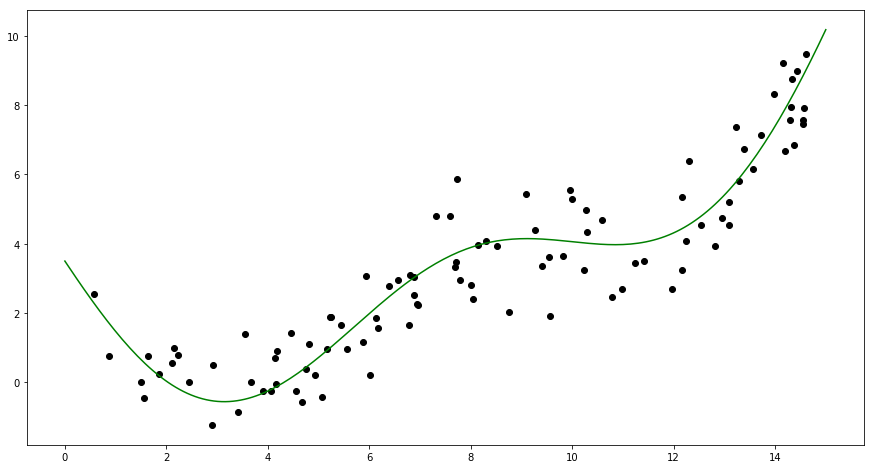

In [5]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 8))

n = 100 # počet měření
data = pd.DataFrame()

# hodnoty x - n hodnot náhodně mezi 0 a 10
data['x'] = np.sort(np.random.rand(n)*15)
data['y'] = fun(data['x']) + np.random.randn(n)*1

meany = np.mean(data['y'])
data['y'] = data['y'] - meany

# hodnoty x na vykreslování funkcí
xgrid = np.linspace(0, 15, 200)[:, None]

# vykreslení
plt.plot(data['x'], data['y']+meany, 'ko',xgrid, vfun(xgrid), 'g-')
print("Zelená čára odpovídá skutečné funkci f(x) a body pak jednotlivým měřením:")

Ukázka použití výše uvedených metod s vybranými parametry. Na parametr gamma je reakce přesně opačná než na šířku pásma.
Pokud je šířka pásma malá (je na ukázce níže) dochazí k přeučení modelu (modrá křivka) a naopak při vysoké se blíží k průměru hodnot. Jsou zahrnuty všechny hodnoty a NW průmeruje jako celek. U přeučení se jedná o průměry téměř pro každý bod.
U gammy je přeučení patrné pro vysoké hodnoty gamma a pro nízké se opět přibližuje k modelování průměrem.

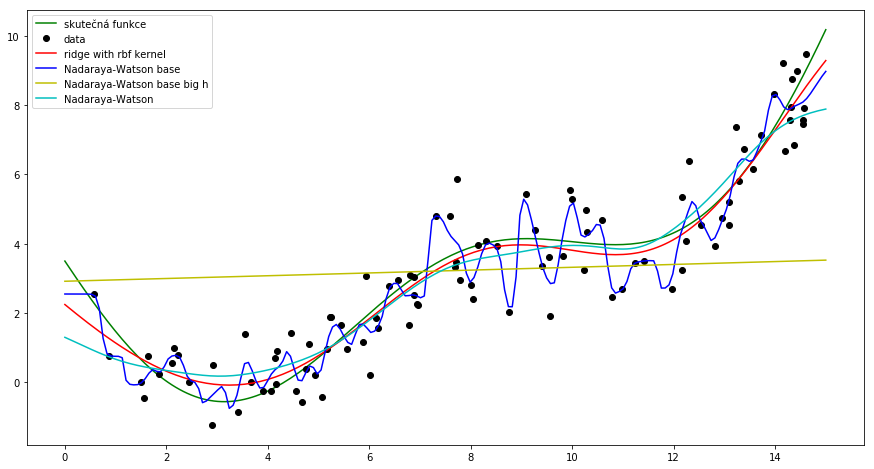

CPU times: user 27.4 s, sys: 2.12 s, total: 29.6 s
Wall time: 27 s


In [6]:
%%time

lambda_ = 0.0034
gamma_ = 0.03
# odlišná gama pro Nadaraya-Watson estimator z duvodu jiného chování oproti hřebenové regresi
gamma2_ = 0.8
# pro změnu v NW base
bandwidth = 0.1


# příprava na metodu nejmenších čtverců
X = np.matrix(data['x']).T
Y = np.matrix(data['y']).T

clf = kernel_ridge.KernelRidge(alpha=lambda_, kernel='rbf', gamma = gamma_)
clf.fit(X, Y) 

NW = Nadaraya_Watson(kernel="rbf", gamma=gamma2_)
NW = NW.fit(X, Y)

# vykreslíme
plt.figure(num=None, figsize=(15, 8))
plt.plot(xgrid, vfun(xgrid), 'g-', label=u'skutečná funkce')
plt.plot(data['x'], data['y']+meany, 'ko',label='data')
plt.plot(xgrid, clf.predict(xgrid)+meany, 'r-', label=u'ridge with rbf kernel')
plt.plot(xgrid, Nadaraya_Watson_base(X, Y, xgrid, bandwidth)+meany, 'b-', label=u'Nadaraya-Watson base')
plt.plot(xgrid, Nadaraya_Watson_base(X, Y, xgrid, 15)+meany, 'y-', label=u'Nadaraya-Watson base big h')
plt.plot(xgrid, NW.predict(xgrid)+meany, 'c-', label=u'Nadaraya-Watson')
plt.legend()
plt.show()

Níže je na datech s minimálním rozptylen ukázáno s čím tento přístup může mít problém. Data jsou téměř bez šumu a jak je vidět hřebenová regrese s rbf jádrem, je témeř přesně na generující funkci. Při využití NW se toto nedaří ani při změně širky pásma a pokud lze data proložit dobře nějakou funkcí (jsou témeř bez šumu), nemusí se to s NW vůbec přesně podařit.

Problém může také nastávat na okrajích predikovaných dat, kde podle grafů vypadá odhad vychýlený.

Zelená čára odpovídá skutečné funkci f(x) a body pak jednotlivým měřením:


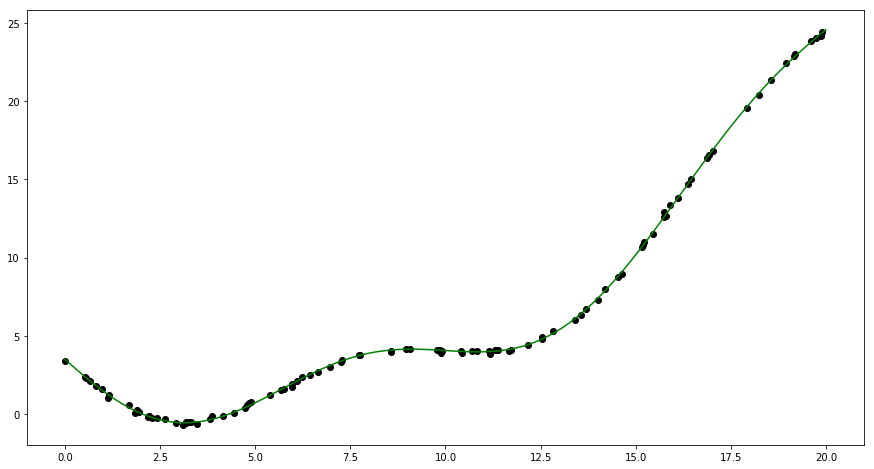

In [7]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 8))

n = 100 # počet měření
data = pd.DataFrame()

# hodnoty x - n hodnot náhodně mezi 0 a 10
data['x'] = np.sort(np.random.rand(n)*20)
data['y'] = fun(data['x']) + np.random.randn(n)*0.1

meany = np.mean(data['y'])
data['y'] = data['y'] - meany

# hodnoty x na vykreslování funkcí
xgrid = np.linspace(0, 20, 200)[:, None]

# vykreslení
plt.plot(data['x'], data['y']+meany, 'ko',xgrid, vfun(xgrid), 'g-')
print("Zelená čára odpovídá skutečné funkci f(x) a body pak jednotlivým měřením:")

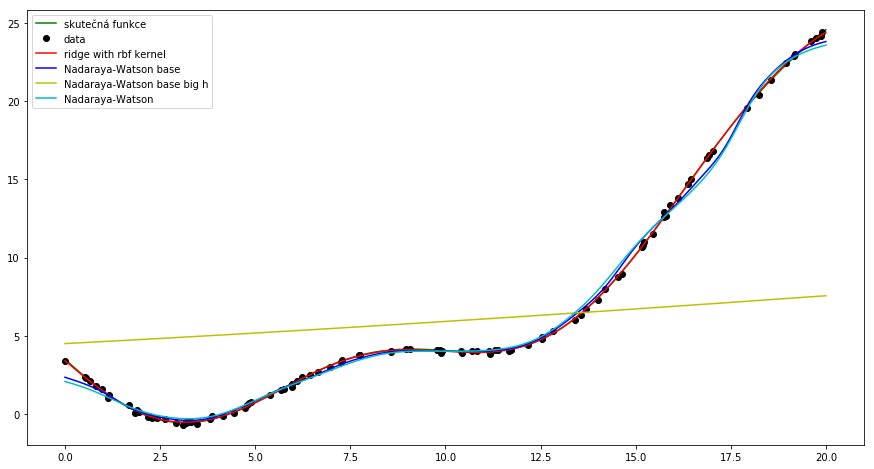

CPU times: user 28 s, sys: 1.99 s, total: 30 s
Wall time: 27.4 s


In [8]:
%%time

lambda_ = 0.0034
gamma_ = 0.03
# odlišná gama pro Nadaraya-Watson estimator z duvodu jiného chování oproti hřebenové regresi
gamma2_ = 0.8
# pro změnu v NW base
bandwidth = 0.6


# příprava na metodu nejmenších čtverců
X = np.matrix(data['x']).T
Y = np.matrix(data['y']).T

clf = kernel_ridge.KernelRidge(alpha=lambda_, kernel='rbf', gamma = gamma_)
clf.fit(X, Y) 

NW = Nadaraya_Watson(kernel="rbf", gamma=gamma2_)
NW = NW.fit(X, Y)

# vykreslíme
plt.figure(num=None, figsize=(15, 8))
plt.plot(xgrid, vfun(xgrid), 'g-', label=u'skutečná funkce')
plt.plot(data['x'], data['y']+meany, 'ko',label='data')
plt.plot(xgrid, clf.predict(xgrid)+meany, 'r-', label=u'ridge with rbf kernel')
plt.plot(xgrid, Nadaraya_Watson_base(X, Y, xgrid, bandwidth)+meany, 'b-', label=u'Nadaraya-Watson base')
plt.plot(xgrid, Nadaraya_Watson_base(X, Y, xgrid, 15)+meany, 'y-', label=u'Nadaraya-Watson base big h')
plt.plot(xgrid, NW.predict(xgrid)+meany, 'c-', label=u'Nadaraya-Watson')
plt.legend()
plt.show()